# Quantum Gaussian process regression



In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import StatePreparation, RYGate
from qiskit.quantum_info import Statevector
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from tqdm import tqdm

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

In [3]:
nx = 4
n = 2

fmin, fmax = 0, 8

nintx = int(np.ceil(np.log2((fmax-fmin))))
npresx = nx - nintx - 1

xmax = np.power(2.,nintx) - np.power(2.,nintx-nx)
xmin = 0.

In [4]:
df = (fmax-fmin)/(2**nx)
T = 1./df
dt = T/2**nx

m1, m2 = 1.4, 1.4
beta, sig = 0., 0.
Tfrac = 100.

def m_geo(m):
    return (4.926e-6)*m

m1 = m_geo(m1)
m2 = m_geo(m2)
tc = T + (T/Tfrac)
DT = tc%T
Mt = m1 + m2
nu = (m1*m2)/Mt
eta = nu/Mt
Mc = Mt*eta**(3./5)
A = 1.e-2

In [5]:
def x_trans(x):
    x = x/xmax
    x = x*(T-dt)
    return x

In [6]:
def phi_t(t, Mc, tc):
    '''
    Return time domain phase given time.
    '''
    return -2.*(((tc-t)/(Mc*5))**(5./8))

def r_t(t, Mt, tc):
    '''
    Return the orbital eeparation given time.
    '''
    return ((256./5)*nu*(Mt**2)*(tc-t))**(1./4)

def h_t(t, Mc, tc):
    return np.cos(phi_t(t, Mc, tc))/r_t(t, Mt, tc)

In [7]:
def y_targ(x):
    t = x_trans(x)
    y_ = A*h_t(t, Mc, tc)
    return np.squeeze(x*np.sin(x))

In [8]:
ls = 2.**(-npresx)
sigma = 1.5
noise_std = 0.75
print(ls, sigma, noise_std)

1.0 1.5 0.75


In [9]:
X = np.linspace(start=xmin, stop=xmax, num=2**nx).reshape(-1, 1)
y = y_targ(X)

In [10]:
X_train = np.linspace(start=xmin, stop=xmax, num=2**n).reshape(-1, 1)
y_train = y_targ(X_train)

In [11]:
print(y)
print(sigma, noise_std)

[ 0.          0.23971277  0.84147098  1.49624248  1.81859485  1.49618036
  0.42336002 -1.2277413  -3.02720998 -4.39888553 -4.79462137 -3.88047179
 -1.67649299  1.39827992  4.59890619  7.03499983]
1.5 0.75


In [12]:
def SEK(X1, X2, ls=1.0, sig=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sig * np.exp(-0.5 * sqdist / ls**2)

In [13]:
def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = SEK(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = SEK(X_train, X_s, l, sigma_f)
    K_ss = SEK(X_s, X_s, l, sigma_f)
    K_inv = np.linalg.inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [14]:
mean_prediction, cov_s = posterior(X, X_train, y_train, l=ls, sigma_f=sigma, sigma_y=noise_std)
std_prediction = np.diag(cov_s)

In [15]:
print(std_prediction)

[0.40893395 0.63785224 0.9968134  0.99659906 0.63754957 0.40877683
 0.63753735 0.99650226 0.99650226 0.63753735 0.40877683 0.63754957
 0.99659906 0.9968134  0.63785224 0.40893395]


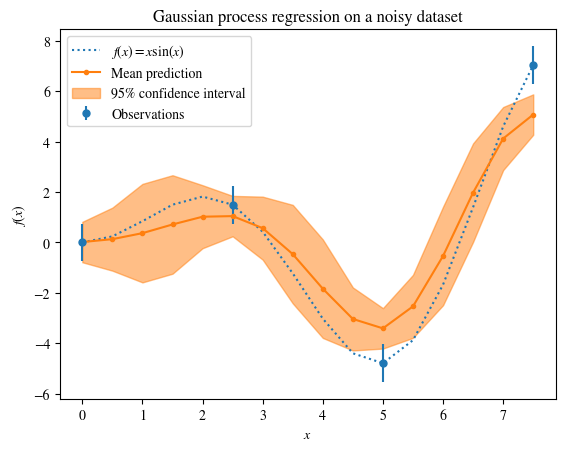

In [16]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction", marker='.')
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [17]:
u_ind = (len(X)//2) - 1

v = y_train
u = SEK(X, X_train, ls, sig=sigma)[u_ind]

v_norm = np.sqrt(np.sum(np.abs(v)**2))
u_norm = np.sqrt(np.sum(np.abs(u)**2))

v_ = v/v_norm
u_ = u/u_norm

In [18]:
A = SEK(X_train, X_train, ls, sig=sigma) + (np.eye(len(X_train))*noise_std**2)

In [19]:
print(A)

[[2.06250000e+00 6.59054004e-02 5.58997976e-06 9.15290502e-13]
 [6.59054004e-02 2.06250000e+00 6.59054004e-02 5.58997976e-06]
 [5.58997976e-06 6.59054004e-02 2.06250000e+00 6.59054004e-02]
 [9.15290502e-13 5.58997976e-06 6.59054004e-02 2.06250000e+00]]


In [20]:
def get_delta(n_l, lambda_min, lambda_max):
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2**n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep

In [21]:
neg_vals = True

kappa = np.linalg.cond(A)
lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))

nanc = np.max([int(np.log2(A.shape[0])) + 1, int(np.ceil(np.log2(kappa + 1)))]) + neg_vals
nanc = nanc * 2

scaling = get_delta(nanc - neg_vals, lambda_min, lambda_max)
t = 2 * np.pi * scaling / lambda_min / (2**neg_vals)

print(t, scaling, nanc, kappa, noise_std**2, lambda_min, lambda_max)

1.4305572829914879 0.890625 8 1.1090433379986444 0.5625 1.9558678218410481 2.1691421778187325


In [22]:
qcont = QuantumRegister(1, 'cont')
qtarg = QuantumRegister(1, 'targ')
qreg = QuantumRegister(n, 'reg')
qanc = QuantumRegister(nanc, 'anc')

circ = QuantumCircuit(qanc, qtarg, qreg, qcont)

In [23]:
circ.h(qcont);

In [24]:
prepv_gate = StatePreparation(Statevector(v_)).control(1)
circ.append(prepv_gate, [qcont, *qreg]);

In [25]:
circ.x(qcont);
circ.cx(qcont, qtarg);
prepu_gate = StatePreparation(Statevector(u_)).control(1)
circ.append(prepu_gate, [qcont, *qreg]);
circ.x(qcont);

In [26]:
hhl_gate = qt.HHL(circ, qreg, qanc, qtarg, A, t=t, scaling=scaling, wrap=True).control(1)
circ.append(hhl_gate, [qcont, *qreg, *qanc, qtarg]);

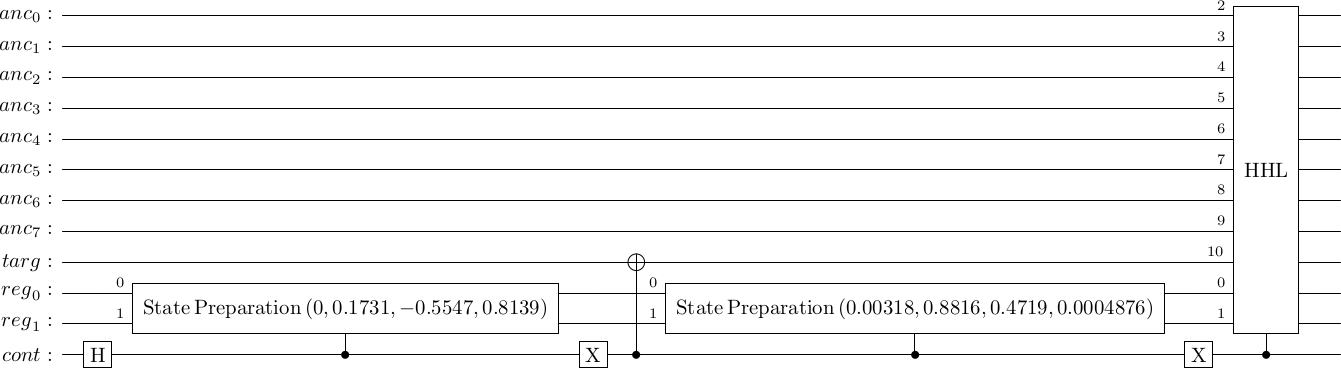

In [27]:
circ.draw('latex')

In [28]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [29]:
state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T

In [30]:
norm_ = np.sqrt(np.sum(np.abs(state_v[:,1])**2))

In [31]:
state_v = state_v[0,1,:,1].real

In [32]:
targ_v = np.matmul(np.linalg.inv(A),v_)

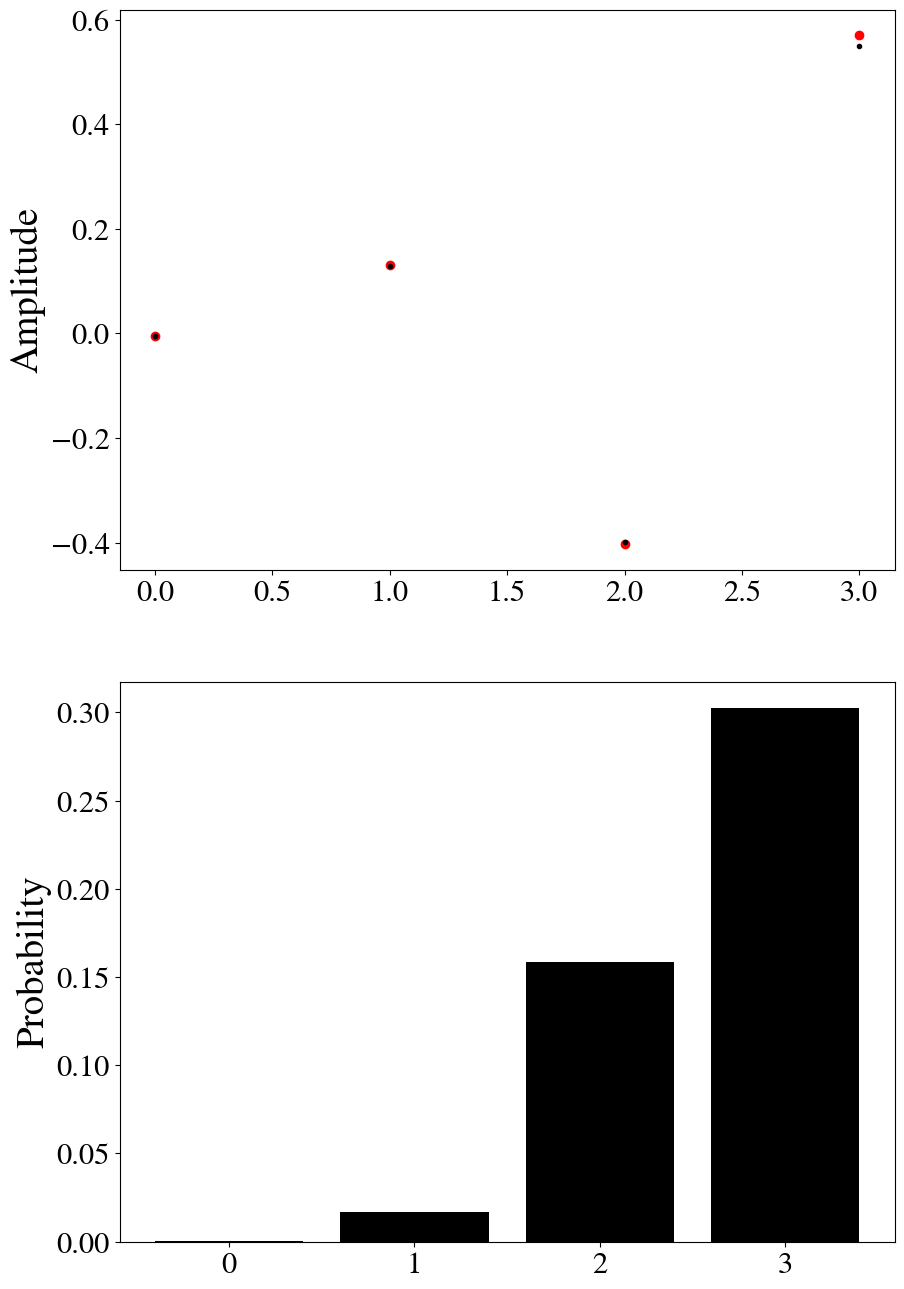

In [33]:
fig = plt.figure(figsize=np.array(figsize)*[1,2])
ax = fig.add_subplot(211)

plt.scatter(np.arange(2**n), targ_v*np.sqrt(2.), marker='o', color='red')
plt.scatter(np.arange(2**n), state_v.real, marker='.', color='black')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

ax = fig.add_subplot(212)

plt.bar(np.arange(2**n), np.abs(state_v)**2, color='black')
ax.set_ylabel('Probability', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [34]:
state_v = state_v.real/np.sqrt(np.sum(np.abs(state_v)**2))
norm = norm_/lambda_min
out = state_v*norm

In [35]:
print(out, targ_v, out/targ_v)

[-0.00404842  0.09450111 -0.29176744  0.40304606] [-0.0029747   0.09311703 -0.28481031  0.40370055] [1.36094941 1.01486387 1.02442721 0.99837876]


In [36]:
state_u = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T

In [37]:
state_u = state_u[0,1,:,0].real

In [38]:
state_u = state_u.real/np.sqrt(np.sum(np.abs(state_u)**2))

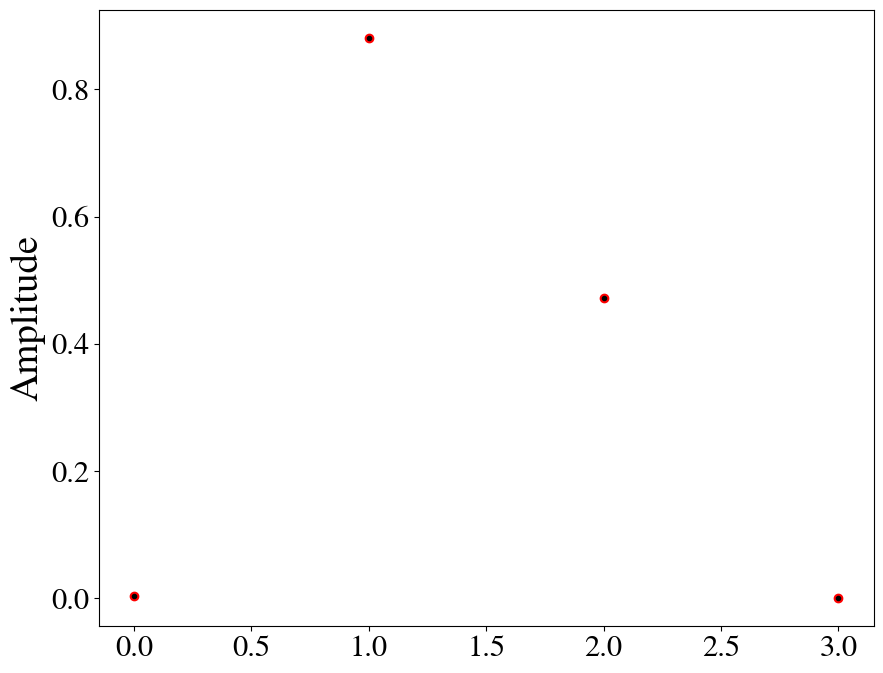

In [39]:
fig = plt.figure(figsize=np.array(figsize))
ax = fig.add_subplot(111)

plt.scatter(np.arange(2**n), u_, marker='o', color='red')
plt.scatter(np.arange(2**n), state_u.real, marker='.', color='black')
ax.set_ylabel('Amplitude', fontsize=fontsize);
ax.tick_params(axis='both', labelsize=ticksize);

In [40]:
state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T

In [41]:
state_v = state_v[0,1].T

In [42]:
X_matrix = np.array([[0,1],[1,0]])

In [43]:
QGPR_out = np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*(u_norm*v_norm*scaling/np.sqrt(2.))
target = mean_prediction[u_ind]

In [44]:
print(QGPR_out, target)

-0.5873416133262492 -0.4649216477555804


In [ ]:
mus = []
stds = []

for i in tqdm(np.arange(2**nx)):
    
    v = y_train
    u = SEK(X, X_train, ls, sig=sigma)[i]

    v_norm = np.sqrt(np.sum(np.abs(v)**2))
    u_norm = np.sqrt(np.sum(np.abs(u)**2))

    v_ = v/v_norm
    u_ = u/u_norm
    
    v_gate = StatePreparation(Statevector(v_))
    u_gate = StatePreparation(Statevector(u_))

    qcont = QuantumRegister(1, 'cont')
    qtarg = QuantumRegister(1, 'targ')
    qreg = QuantumRegister(n, 'reg')
    qanc = QuantumRegister(nanc, 'anc')

    circ = QuantumCircuit(qanc, qtarg, qreg, qcont)
        
    QGPR_gate = qt.QGPR(circ, qreg, qanc, qtarg, qcont, v_gate, u_gate, A, t, scaling, wrap=True)
    circ.append(QGPR_gate, [*qreg, *qanc, qtarg, qcont]);
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T[0,1].T
    mus.append(np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*(u_norm*v_norm*scaling/np.sqrt(2)))
    
    qcont = QuantumRegister(1, 'cont')
    qtarg = QuantumRegister(1, 'targ')
    qreg = QuantumRegister(n, 'reg')
    qanc = QuantumRegister(nanc, 'anc')

    circ = QuantumCircuit(qanc, qtarg, qreg, qcont)
        
    QGPR_gate = qt.QGPR(circ, qreg, qanc, qtarg, qcont, u_gate, u_gate, A, t, scaling, wrap=True)
    circ.append(QGPR_gate, [*qreg, *qanc, qtarg, qcont]);
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    state_vector = np.asarray(result.get_statevector())
    
    state_v = np.asarray(state_vector).reshape((2**1, 2**n, 2**1, 2**nanc)).T[0,1].T
    M_exp = np.matmul(state_v.flatten(),np.matmul(X_matrix, state_v.real).flatten()).real*((u_norm**2)*scaling/np.sqrt(2))

    stds.append(SEK(X, X, ls, sig=sigma)[i,i]-M_exp)
    
mus = np.array(mus)
stds = np.array(stds)

 62%|██████████████████████████▉                | 10/16 [01:17<00:47,  7.90s/it]

In [ ]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, marker='.', label="Classical mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.plot(X, mus, color='violet', marker='.', label="Quantum mean prediction")
plt.fill_between(
    X.ravel(),
    mus - 1.96 * stds,
    mus + 1.96 * stds,
    color="tab:purple",
    alpha=0.5,
    label=r"95% confidence interval",
)

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [ ]:
np.linalg.inv(A).dot(A)